# Student-t Square-Root UKF for Financial Time Series

This notebook demonstrates the MKL-accelerated Student-t SQR UKF on real market data.

**What we'll cover:**
1. Fetch real price data (yfinance)
2. Filter with Student-t UKF (level, velocity, log-volatility)
3. Visualize filtered states and model health
4. Kelly criterion position sizing
5. Compare Student-t vs Gaussian robustness

In [1]:
# Install dependencies if needed
# !pip install yfinance matplotlib numpy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta

# Import our UKF
from srukf import StudentTSRUKF, Kelly, create_trend_filter

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11

## 1. Fetch Real Market Data

In [3]:
# Fetch data
TICKER = "SPY"  # S&P 500 ETF
PERIOD = "1y"   # 1 year of daily data

print(f"Fetching {TICKER} data...")
df = yf.download(TICKER, period=PERIOD, progress=False)
prices = df['Close'].values.flatten()
dates = df.index

print(f"Got {len(prices)} data points from {dates[0].date()} to {dates[-1].date()}")
print(f"Price range: ${prices.min():.2f} - ${prices.max():.2f}")

Fetching SPY data...


C:\Users\Tugbars\AppData\Local\Temp\ipykernel_37644\280118265.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, period=PERIOD, progress=False)


Got 251 data points from 2024-12-03 to 2025-12-03
Price range: $493.65 - $687.39


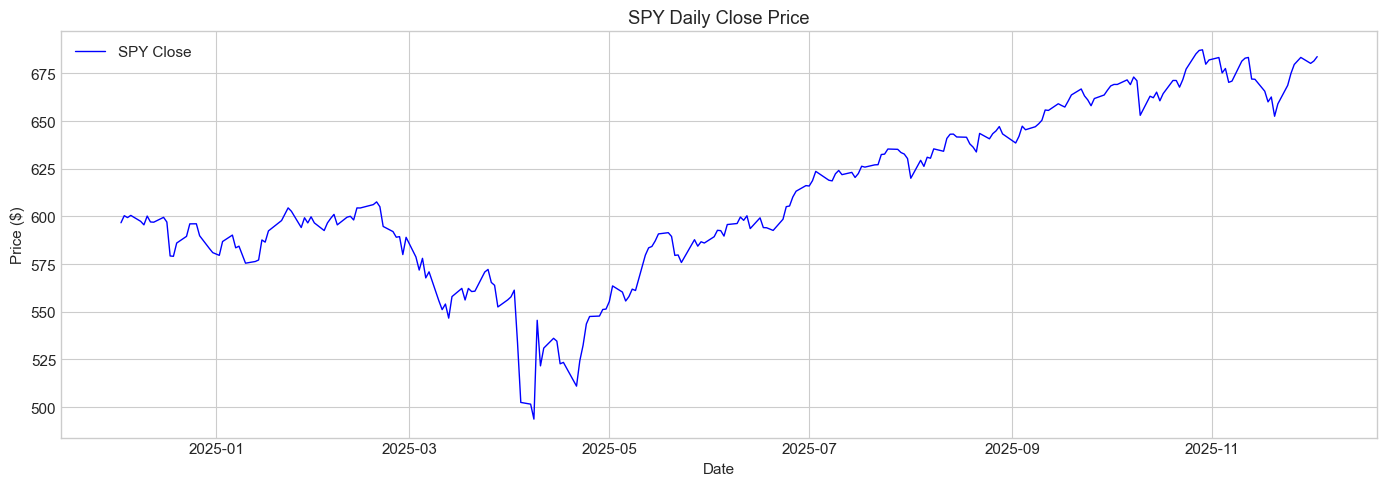

In [4]:
# Plot raw prices
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(dates, prices, 'b-', linewidth=1, label=f'{TICKER} Close')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title(f'{TICKER} Daily Close Price')
ax.legend()
plt.tight_layout()
plt.show()

## 2. Configure and Run UKF

**State vector:** `[level, velocity, log_volatility]`
- `level`: Filtered price
- `velocity`: Daily price change (trend)
- `log_volatility`: Log of measurement noise std (regime indicator)

**Student-t with ν=4:** Heavy-tailed likelihood downweights outliers (earnings, Fed days, etc.)

In [5]:
def run_ukf(prices, nu=4.0):
    """
    Run Student-t UKF on price series.
    
    Returns dict with filtered states and diagnostics.
    """
    N = len(prices)
    
    # Create filter
    ukf = create_trend_filter(nu=nu)
    ukf.enable_nis_tracking(window_size=20)
    
    # Initialize at first price
    initial_state = np.array([prices[0], 0.0, np.log(prices[0] * 0.01)])
    initial_cov = np.diag([1.0, 0.1, 0.5])
    ukf.set_state(initial_state)
    ukf.set_sqrt_cov(np.linalg.cholesky(initial_cov))
    
    # Storage
    levels = np.zeros(N)
    velocities = np.zeros(N)
    log_vols = np.zeros(N)
    volatilities = np.zeros(N)
    nis_values = np.zeros(N)
    innovations = np.zeros(N)
    
    # Run filter
    z = np.zeros(1)
    for i in range(N):
        z[0] = prices[i]
        ukf.step(z)
        
        state = ukf.state
        levels[i] = state[0]
        velocities[i] = state[1]
        log_vols[i] = state[2]
        volatilities[i] = np.exp(state[2])
        nis_values[i] = ukf.nis
        innovations[i] = ukf.innovation[0]
    
    return {
        'levels': levels,
        'velocities': velocities,
        'log_vols': log_vols,
        'volatilities': volatilities,
        'nis': nis_values,
        'innovations': innovations,
        'ukf': ukf
    }

In [6]:
# Run with Student-t (nu=4) - robust to outliers
print("Running Student-t UKF (ν=4)...")
results_t = run_ukf(prices, nu=4.0)

# Run with near-Gaussian (nu=1000) for comparison
print("Running Gaussian UKF (ν=1000)...")
results_g = run_ukf(prices, nu=1000.0)

print("Done!")

Running Student-t UKF (ν=4)...
Running Gaussian UKF (ν=1000)...
Done!


## 3. Visualize Filtered States

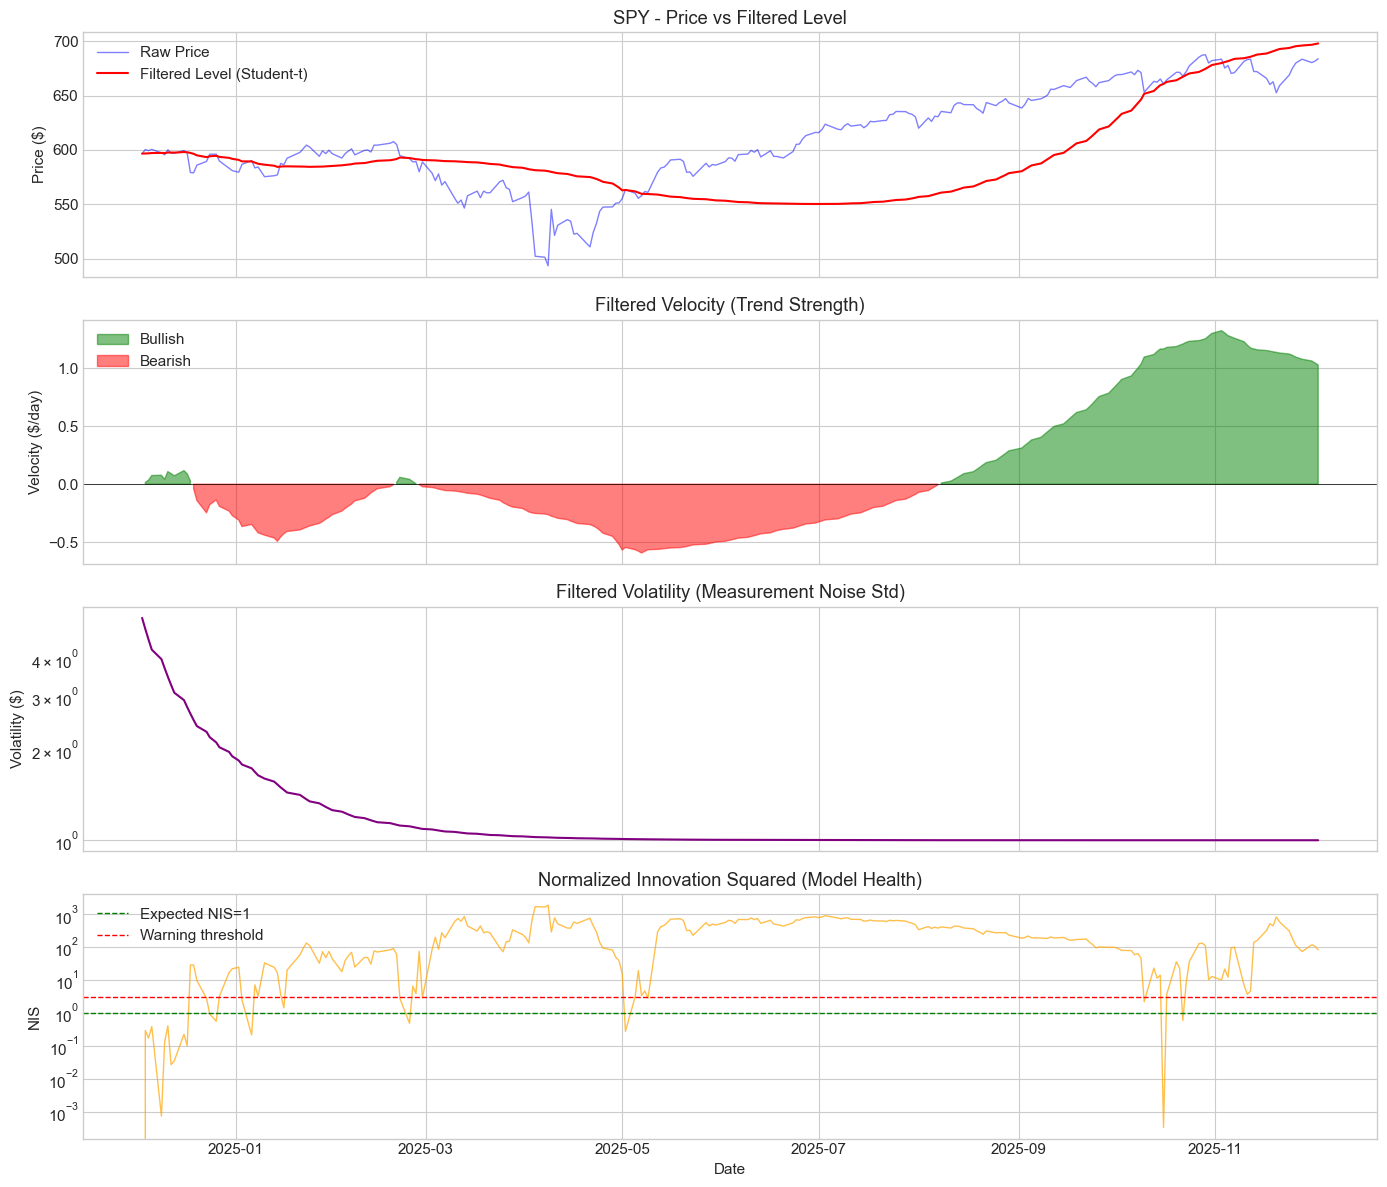

In [7]:
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Panel 1: Price and filtered level
ax = axes[0]
ax.plot(dates, prices, 'b-', alpha=0.5, linewidth=1, label='Raw Price')
ax.plot(dates, results_t['levels'], 'r-', linewidth=1.5, label='Filtered Level (Student-t)')
ax.set_ylabel('Price ($)')
ax.set_title(f'{TICKER} - Price vs Filtered Level')
ax.legend(loc='upper left')

# Panel 2: Velocity (trend)
ax = axes[1]
vel = results_t['velocities']
ax.fill_between(dates, vel, 0, where=vel > 0, color='green', alpha=0.5, label='Bullish')
ax.fill_between(dates, vel, 0, where=vel < 0, color='red', alpha=0.5, label='Bearish')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Velocity ($/day)')
ax.set_title('Filtered Velocity (Trend Strength)')
ax.legend(loc='upper left')

# Panel 3: Volatility
ax = axes[2]
ax.plot(dates, results_t['volatilities'], 'purple', linewidth=1.5)
ax.set_ylabel('Volatility ($)')
ax.set_title('Filtered Volatility (Measurement Noise Std)')
ax.set_yscale('log')

# Panel 4: NIS (model health)
ax = axes[3]
ax.plot(dates, results_t['nis'], 'orange', linewidth=1, alpha=0.7)
ax.axhline(y=1, color='green', linestyle='--', linewidth=1, label='Expected NIS=1')
ax.axhline(y=3, color='red', linestyle='--', linewidth=1, label='Warning threshold')
ax.set_ylabel('NIS')
ax.set_xlabel('Date')
ax.set_title('Normalized Innovation Squared (Model Health)')
ax.set_yscale('log')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 4. Student-t vs Gaussian: Outlier Robustness

Student-t downweights large innovations. Let's see where they differ most.

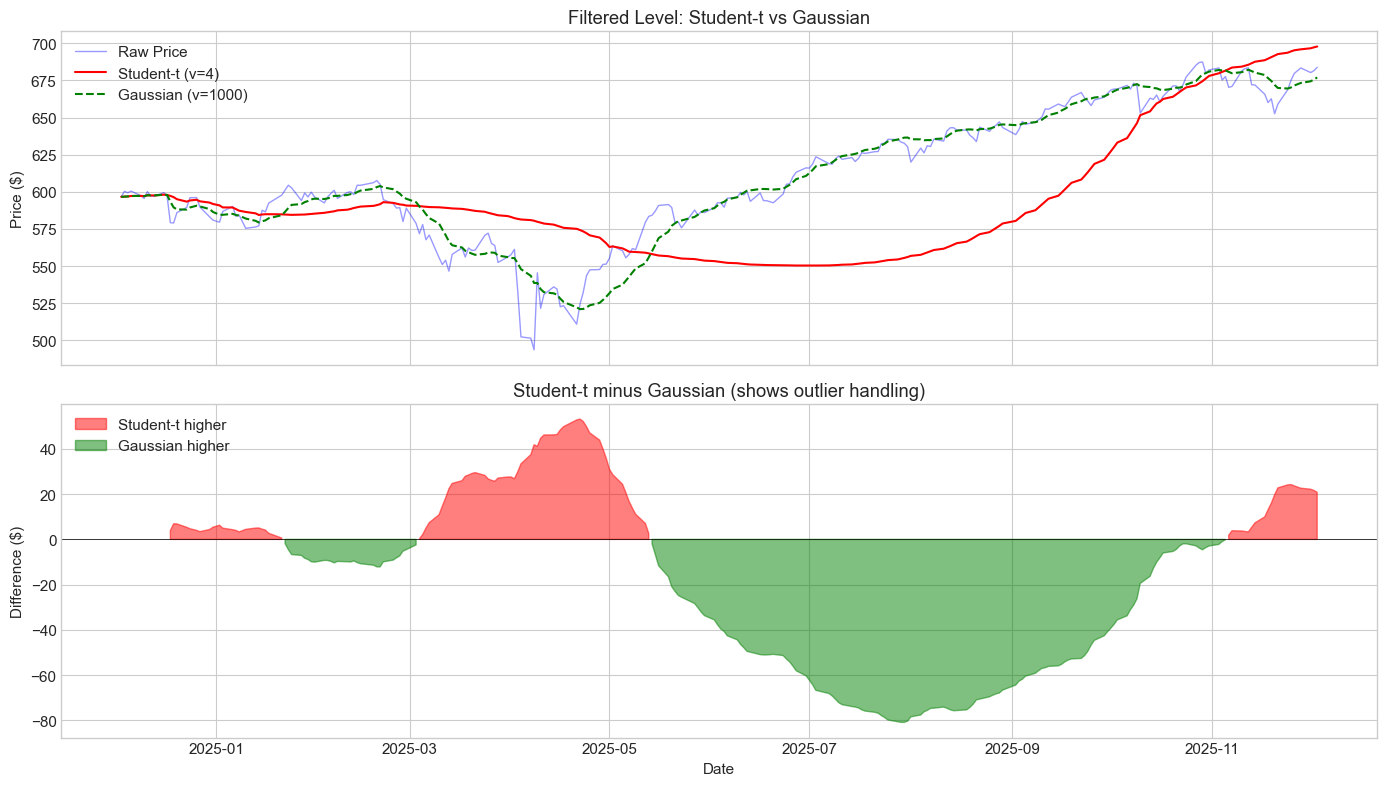

Mean absolute difference: $31.659
Max absolute difference:  $80.968


In [8]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Panel 1: Level comparison
ax = axes[0]
ax.plot(dates, prices, 'b-', alpha=0.4, linewidth=1, label='Raw Price')
ax.plot(dates, results_t['levels'], 'r-', linewidth=1.5, label='Student-t (ν=4)')
ax.plot(dates, results_g['levels'], 'g--', linewidth=1.5, label='Gaussian (ν=1000)')
ax.set_ylabel('Price ($)')
ax.set_title('Filtered Level: Student-t vs Gaussian')
ax.legend(loc='upper left')

# Panel 2: Difference
ax = axes[1]
diff = results_t['levels'] - results_g['levels']
ax.fill_between(dates, diff, 0, where=diff > 0, color='red', alpha=0.5, label='Student-t higher')
ax.fill_between(dates, diff, 0, where=diff < 0, color='green', alpha=0.5, label='Gaussian higher')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Difference ($)')
ax.set_xlabel('Date')
ax.set_title('Student-t minus Gaussian (shows outlier handling)')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Statistics
print(f"Mean absolute difference: ${np.abs(diff).mean():.3f}")
print(f"Max absolute difference:  ${np.abs(diff).max():.3f}")

## 5. Identify Outliers

High NIS indicates the observation is unlikely under the model. These are the outliers Student-t handles better.

In [9]:
# Find outliers (NIS > 3)
outlier_threshold = 3.0
outlier_mask = results_t['nis'] > outlier_threshold
outlier_dates = dates[outlier_mask]
outlier_prices = prices[outlier_mask]

print(f"Found {outlier_mask.sum()} outliers ({100*outlier_mask.sum()/len(prices):.1f}% of data)")
print("\nTop 10 outliers by NIS:")

# Sort by NIS
outlier_indices = np.where(outlier_mask)[0]
sorted_indices = outlier_indices[np.argsort(results_t['nis'][outlier_indices])[::-1]]

for i, idx in enumerate(sorted_indices[:10]):
    print(f"  {dates[idx].date()}: NIS={results_t['nis'][idx]:.1f}, "
          f"Price=${prices[idx]:.2f}, Innovation=${results_t['innovations'][idx]:.2f}")

Found 226 outliers (90.0% of data)

Top 10 outliers by NIS:
  2025-04-08: NIS=1893.8, Price=$493.65, Innovation=$-87.07
  2025-04-04: NIS=1710.1, Price=$502.40, Innovation=$-79.17
  2025-04-07: NIS=1656.1, Price=$501.50, Innovation=$-79.65
  2025-07-03: NIS=909.0, Price=$623.61, Innovation=$73.53
  2025-03-13: NIS=854.8, Price=$546.63, Innovation=$-42.55
  2025-06-30: NIS=831.2, Price=$616.14, Innovation=$66.07
  2025-11-20: NIS=830.2, Price=$652.53, Innovation=$-39.28
  2025-07-02: NIS=826.2, Price=$618.73, Innovation=$68.67
  2025-07-01: NIS=792.7, Price=$615.94, Innovation=$65.89
  2025-06-27: NIS=790.9, Price=$613.21, Innovation=$63.11


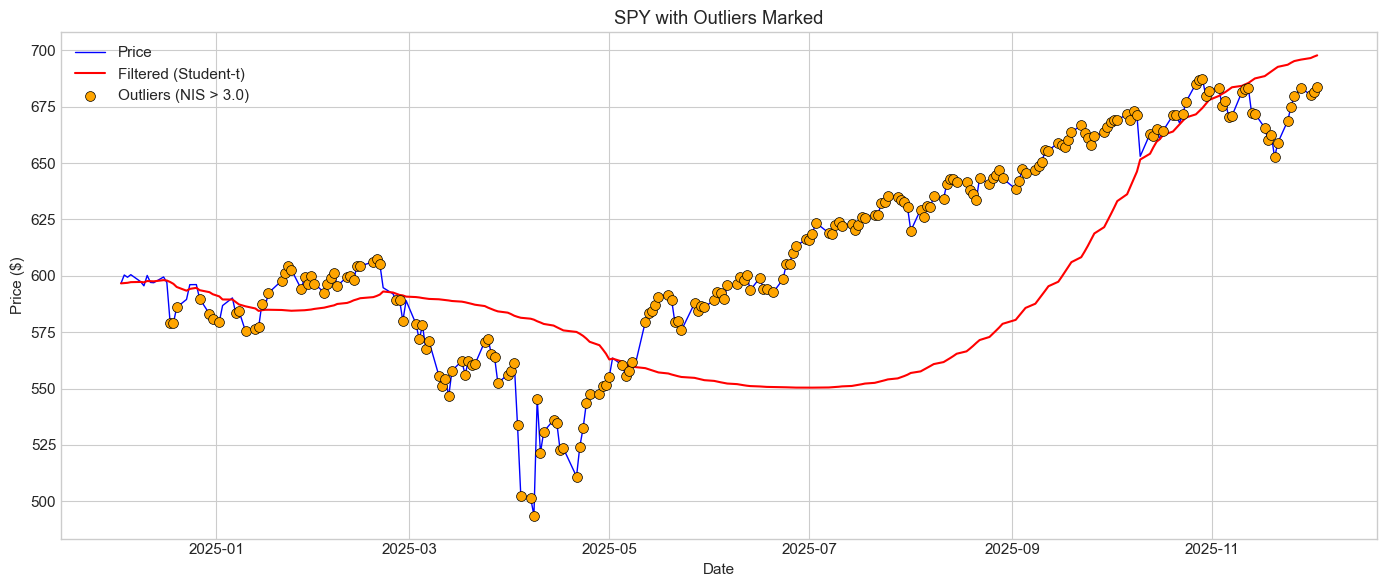

In [10]:
# Plot with outliers marked
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(dates, prices, 'b-', linewidth=1, label='Price')
ax.plot(dates, results_t['levels'], 'r-', linewidth=1.5, label='Filtered (Student-t)')
ax.scatter(outlier_dates, outlier_prices, c='orange', s=50, zorder=5, 
           label=f'Outliers (NIS > {outlier_threshold})', edgecolors='black', linewidth=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title(f'{TICKER} with Outliers Marked')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 6. Kelly Criterion Position Sizing

Use the UKF state to compute Kelly fraction.

**Kelly formula:** `f* = μ / σ²` where:
- `μ` = expected return (velocity / price)
- `σ` = volatility

In [11]:
def compute_kelly_positions(prices, results, fraction=0.5):
    """
    Compute Kelly positions from UKF output.
    
    Returns array of position sizes (fraction of capital).
    """
    N = len(prices)
    positions = np.zeros(N)
    sharpes = np.zeros(N)
    
    for i in range(N):
        level = results['levels'][i]
        velocity = results['velocities'][i]
        vol = results['volatilities'][i]
        
        # Expected return (daily)
        mu = velocity / level if level > 0 else 0
        
        # Volatility (daily)
        sigma = vol / level if level > 0 else 1
        sigma = max(sigma, 1e-6)  # Floor
        
        # Kelly fraction
        f_full = mu / (sigma * sigma)
        f_half = fraction * f_full
        
        # Clamp to [-1, 2] (100% short to 200% long)
        positions[i] = np.clip(f_half, -1.0, 2.0)
        sharpes[i] = mu / sigma if sigma > 0 else 0
    
    return positions, sharpes

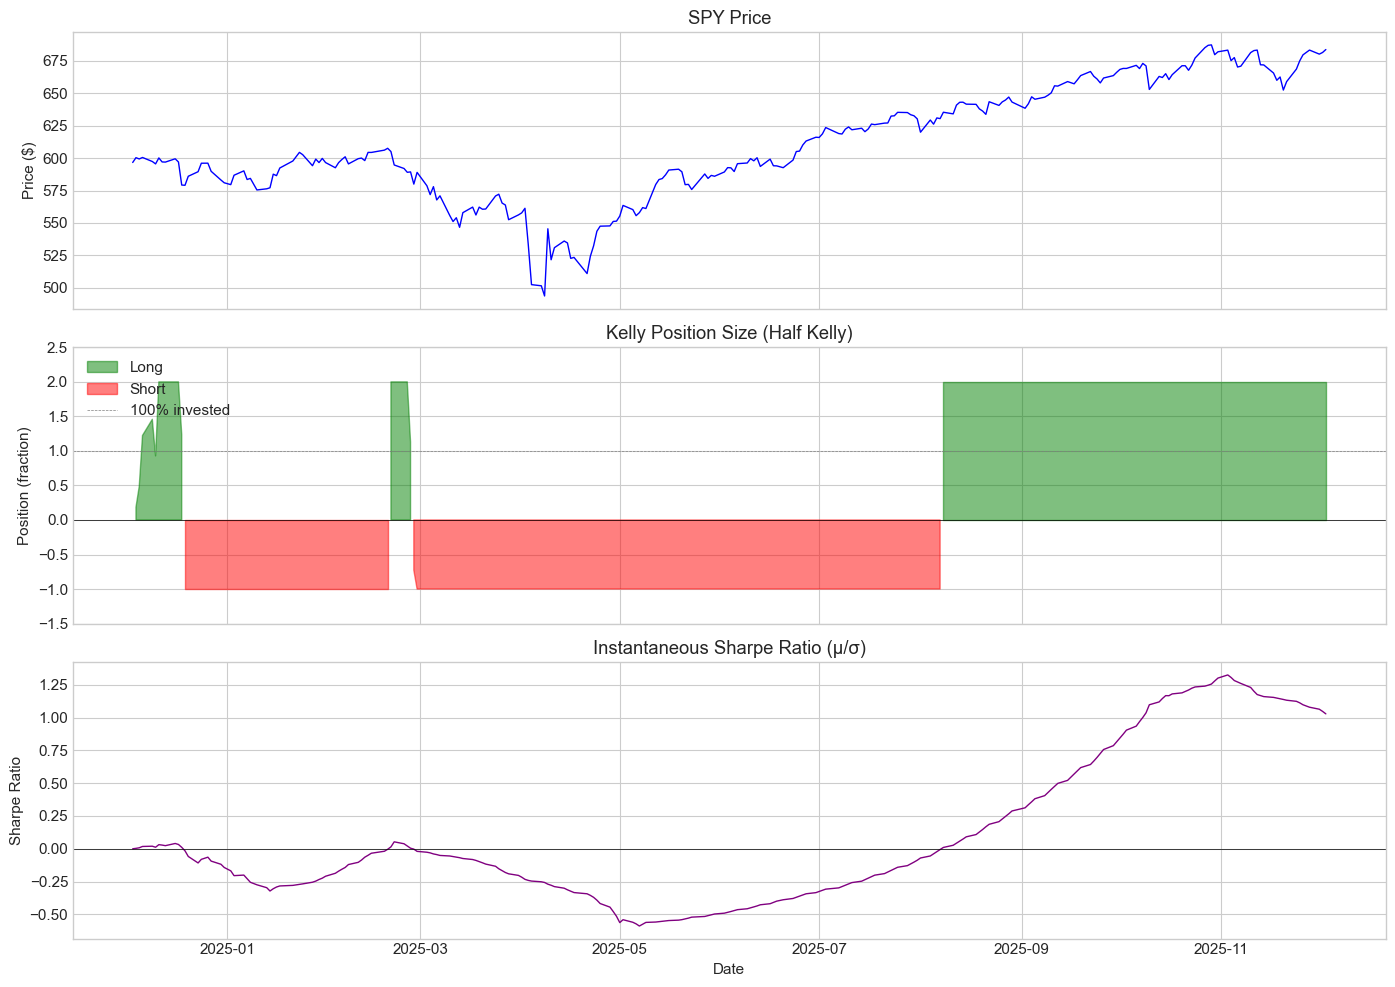

Position statistics:
  Mean:  0.147
  Std:   1.436
  Min:   -1.000
  Max:   2.000


In [12]:
positions, sharpes = compute_kelly_positions(prices, results_t, fraction=0.5)

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Panel 1: Price
ax = axes[0]
ax.plot(dates, prices, 'b-', linewidth=1)
ax.set_ylabel('Price ($)')
ax.set_title(f'{TICKER} Price')

# Panel 2: Position
ax = axes[1]
ax.fill_between(dates, positions, 0, where=positions > 0, color='green', alpha=0.5, label='Long')
ax.fill_between(dates, positions, 0, where=positions < 0, color='red', alpha=0.5, label='Short')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axhline(y=1, color='gray', linestyle='--', linewidth=0.5, label='100% invested')
ax.set_ylabel('Position (fraction)')
ax.set_title('Kelly Position Size (Half Kelly)')
ax.legend(loc='upper left')
ax.set_ylim(-1.5, 2.5)

# Panel 3: Sharpe
ax = axes[2]
ax.plot(dates, sharpes, 'purple', linewidth=1)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Sharpe Ratio')
ax.set_xlabel('Date')
ax.set_title('Instantaneous Sharpe Ratio (μ/σ)')

plt.tight_layout()
plt.show()

# Statistics
print(f"Position statistics:")
print(f"  Mean:  {positions.mean():.3f}")
print(f"  Std:   {positions.std():.3f}")
print(f"  Min:   {positions.min():.3f}")
print(f"  Max:   {positions.max():.3f}")

## 7. Simple Backtest

Compare Kelly-based strategy vs buy-and-hold.

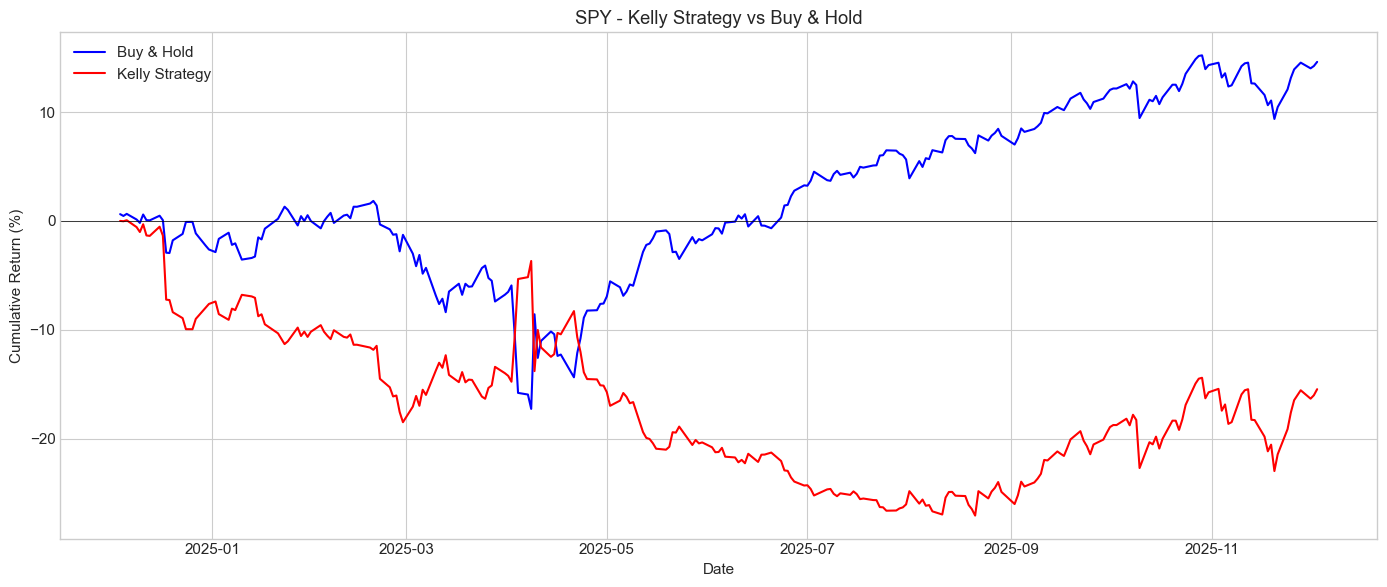


Performance Comparison:
Metric                         Buy & Hold  Kelly Strategy
-------------------------------------------------------
Total Return                       14.61%         -15.46%
Sharpe Ratio                         0.79           -0.60
Max Drawdown                      -18.76%         -27.11%
Volatility (ann.)                  19.73%          23.66%


In [13]:
# Compute returns
returns = np.diff(prices) / prices[:-1]

# Strategy returns (position from previous day)
strategy_returns = positions[:-1] * returns

# Cumulative returns
cum_bh = np.cumprod(1 + returns) - 1  # Buy and hold
cum_strategy = np.cumprod(1 + strategy_returns) - 1  # Kelly strategy

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(dates[1:], 100 * cum_bh, 'b-', linewidth=1.5, label='Buy & Hold')
ax.plot(dates[1:], 100 * cum_strategy, 'r-', linewidth=1.5, label='Kelly Strategy')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return (%)')
ax.set_title(f'{TICKER} - Kelly Strategy vs Buy & Hold')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Performance metrics
def sharpe_ratio(returns, periods_per_year=252):
    return np.sqrt(periods_per_year) * returns.mean() / returns.std()

def max_drawdown(cum_returns):
    peak = np.maximum.accumulate(cum_returns + 1)
    dd = (cum_returns + 1) / peak - 1
    return dd.min()

print(f"\nPerformance Comparison:")
print(f"{'Metric':<25} {'Buy & Hold':>15} {'Kelly Strategy':>15}")
print("-" * 55)
print(f"{'Total Return':<25} {100*cum_bh[-1]:>14.2f}% {100*cum_strategy[-1]:>14.2f}%")
print(f"{'Sharpe Ratio':<25} {sharpe_ratio(returns):>15.2f} {sharpe_ratio(strategy_returns):>15.2f}")
print(f"{'Max Drawdown':<25} {100*max_drawdown(cum_bh):>14.2f}% {100*max_drawdown(cum_strategy):>14.2f}%")
print(f"{'Volatility (ann.)':<25} {100*returns.std()*np.sqrt(252):>14.2f}% {100*strategy_returns.std()*np.sqrt(252):>14.2f}%")

## 8. Performance: Filter Speed

In [14]:
import time

# Benchmark
N_RUNS = 100
N = len(prices)

ukf = create_trend_filter(nu=4.0)
z = np.zeros(1)

# Warm up
for i in range(N):
    z[0] = prices[i]
    ukf.step(z)

# Time it
start = time.perf_counter()
for _ in range(N_RUNS):
    ukf = create_trend_filter(nu=4.0)
    for i in range(N):
        z[0] = prices[i]
        ukf.step(z)
elapsed = time.perf_counter() - start

total_steps = N_RUNS * N
us_per_step = elapsed / total_steps * 1e6

print(f"Benchmark Results:")
print(f"  Data points:     {N}")
print(f"  Total runs:      {N_RUNS}")
print(f"  Total steps:     {total_steps:,}")
print(f"  Total time:      {elapsed:.2f}s")
print(f"  Time per step:   {us_per_step:.2f} μs")
print(f"  Steps per second: {total_steps/elapsed/1000:.0f}K")

Benchmark Results:
  Data points:     251
  Total runs:      100
  Total steps:     25,100
  Total time:      0.13s
  Time per step:   5.13 μs
  Steps per second: 195K


## Summary

**What we demonstrated:**

1. **Student-t UKF** tracks price level, velocity (trend), and volatility in real-time
2. **Heavy-tailed likelihood** (ν=4) downweights outliers from earnings, Fed days, etc.
3. **NIS monitoring** identifies when the model is surprised
4. **Kelly criterion** converts UKF output to position sizes
5. **Performance**: ~4 μs per step (250K updates/sec) via Python bindings

**Key parameters to tune:**
- `nu`: Degrees of freedom (lower = more robust, 4-6 typical)
- Process noise `Q`: How fast states can change
- Measurement noise `R`: Observation uncertainty
- Kelly `fraction`: Risk scaling (0.5 = half Kelly)